In [1]:
import os, sys
%pylab notebook
import emcee

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import corner
from getdist import plots, MCSamples
import getdist

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

figpath="./results/" ; ensure_dir(figpath)
datapath="/Users/adityarotti/Documents/Work/Data/Planck/"

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/getdist/plots.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/traitlets/config/application.py

# Get data

In [2]:
data_stat={}
data_stat["orig"]={}
data_stat["orig"]["tot"]=loadtxt("../../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
data_stat["orig"]["urc6"]=loadtxt("../../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")

data_stat["rec"]={}
data_stat["rec"]["tot"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
data_stat["rec"]["urc6"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")

data_stat["cib_dep"]={}
data_stat["cib_dep"]["tot"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask_cib_dep/data/total_yy_spec.txt")
data_stat["cib_dep"]["urc6"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask_cib_dep/data/unresolved_yy_spec.txt")

# Upstream
data_stat["cib_dep_us"]={}
data_stat["cib_dep_us"]["tot"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask_cib_dep_us/data/total_yy_spec.txt")
data_stat["cib_dep_us"]["urc6"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask_cib_dep_us/data/unresolved_yy_spec.txt")


# Downstream
data_stat["cib_dep_ds"]={}
data_stat["cib_dep_ds"]["tot"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask_cib_dep_ds/data/total_yy_spec.txt")
data_stat["cib_dep_ds"]["urc6"]=loadtxt("../../../results/cib_dep_yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask_cib_dep_ds/data/unresolved_yy_spec.txt")

fsky={}
fsky["tot"]=0.35443
fsky["urc"]=0.344612
fsky["rc"]=0.35443

# Get theory spectra

In [3]:
def return_planck_ell_dl():
    planckyy=np.loadtxt(datapath + "/maps/planck2015_yy_ps.txt")
    bmin=planckyy[:,3]
    bmax=planckyy[:,4]
    ell=[]
    dl=[]
    for i in range(len(bmin)):
        ll=np.linspace(bmin[i],bmax[i],bmax[i]-bmin[i]+1)
        ell=ell + [np.mean(ll)]
        dl = dl + [len(ll)]
    return np.array(ell),np.array(dl)

ellp,dlp=return_planck_ell_dl()

def return_binned_spec(data,fsky,ellp=[],dlp=[],Tll_fsky=1):
    if ellp==[]:
        ellp=data[:,0]
    if dlp==[]:
        dlp=data[:,0]*0.4
        
    clyy_plb={}
    
    ell=data[:,0] ; fl=ell*(ell+1)/(2.*pi)
    clyy_plb["ell"]=ellp
    clyy_plb["fl"]=ellp*(ellp+1.)/(2.*pi)
    
    # 1 Halo term
    clyy=data[:,1]/fl
    clyy_plb["1h"]=10.**np.interp(np.log10(ellp),np.log10(ell),np.log10(clyy))
    
    #  2 halo term
    clyy=data[:,6]/fl
    clyy_plb["2h"]=10.**np.interp(np.log10(ellp),np.log10(ell),np.log10(clyy))
    
    # 1 halo + 2 halo
    clyy_plb["1h2h"]=clyy_plb["1h"] + clyy_plb["2h"]
    
    # 1 halo Gaussian error
    clyy_var=(clyy**2)*(2./(2.*ell+1))
    clyy_plb["1h_Gerr"]=clyy_plb["1h"]*np.sqrt(2./((2.*ellp+1)*dlp*fsky))
    
    # Total Gaussian error
    clyy_plb["1h2h_Gerr"]=(clyy_plb["1h"]+clyy_plb["2h"])*np.sqrt(2./((2.*ellp+1)*dlp*fsky))
    
    # Trispectrum diagonal error
    Tll=data[:,3]
    clyy_plb["1h_Terr"]=np.sqrt(10.**np.interp(np.log10(ellp),np.log10(ell),np.log10(Tll/Tll_fsky)))
    
    # Total error
    clyy_plb["tot_err"]=np.sqrt(clyy_plb["1h2h_Gerr"]**2. + clyy_plb["1h_Terr"]**2.)
    return clyy_plb

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


In [4]:
ellp,dlp=return_planck_ell_dl()

clyy={}
data=loadtxt("../../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_total.txt")
clyy["tot"]=return_binned_spec(data,fsky["tot"],ellp,dlp)

data=loadtxt("../../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_diffuse_snr_6.txt")
clyy["urc6"]=return_binned_spec(data,fsky["urc"],ellp,dlp)


data=loadtxt("../../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_total.txt")
T_tot=np.loadtxt("../../../tempdata/rotti_20_1_6_50/tSZ_trispectrum_ref_rotti++20_total_fsky_0d47.txt")/(4.*pi*0.354430)
T_urc6=np.loadtxt("../../../tempdata/rotti_20_1_6_50/tSZ_trispectrum_ref_rotti++20_urc_snr6_fsky_0d35443.txt")/(4.*pi*0.354430)


fn_tot=interp2d(log10(data[:,0]),log10(data[:,0]),log10(T_tot))

tcov={}
tcov["tot"]=np.zeros((len(ellp),len(ellp)),dtype=np.float64)
for i,lp1 in enumerate(ellp):
    for j,lp2 in enumerate(ellp):
        tcov["tot"][i,j]=10.**fn_tot(log10(lp1),log10(lp2))
        
fn_urc6=interp2d(data[:,0],data[:,0],T_urc6)
tcov["urc6"]=np.zeros((len(ellp),len(ellp)),dtype=np.float64)
for i,lp1 in enumerate(ellp):
    for j,lp2 in enumerate(ellp):
        tcov["urc6"][i,j]=fn_urc6(lp1,lp2)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


# The likelihood setup

- $- 2 ln \mathcal{L} = [C_{\ell}^{\rm Data} - C_{\ell}^{Model}] \mathcal{N}^{-1} [C_{\ell}^{\rm Data} - C_{\ell}^{Model}]$
- $C_{\ell}^{Model} = F_{\rm SZ}C_{\ell}^{yy} + A_{\rm CIB}C_{\ell}^{\rm CIB} + A_{\rm IR}C_{\ell}^{\rm IR} + A_{\rm RS}C_{\ell}^{\rm RS}$

In [9]:
class fit_yy_params(object):
    def __init__(self,cl_data,cl_gcov,cl_tcov,cl_thry,cl_cib,cl_rs,cl_ir,cl_cn):
        self.cl_data=cl_data
        self.cl_gcov=cl_gcov
        self.cl_tcov=cl_tcov
        self.cl_thry=cl_thry
        self.cl_cib=cl_cib
        self.cl_rs=cl_rs
        self.cl_ir=cl_ir
        self.cl_cn=cl_cn
     
    def return_model(self,param):
        F_sz,A_cib,A_ir,A_rs,A_cn = param
        cl_model=F_sz*self.cl_thry + A_cib*self.cl_cib + A_rs*self.cl_rs + A_ir*self.cl_ir + A_cn*self.cl_cn
        model_cov=F_sz*F_sz*self.cl_tcov + np.diag(self.cl_gcov**2.)
        return cl_model,model_cov
    
    def lnlike(self,param):
        cl_model,model_cov=self.return_model(param)
        total_cov_inv=np.linalg.inv(model_cov)
        dvec=(self.cl_data - cl_model)
        return -0.5*np.dot(dvec,np.dot(total_cov_inv,dvec).T)
    
    def lnprior(self,param):
        F_sz,A_cib,A_ir,A_rs,A_cn = param
        if 0. <= F_sz < 2. and 0. <= A_cib < 5.  and 0. <= A_ir < 5.  and 0. <= A_rs < 5. and 0. <= A_cn < 10. :
            return 0.0
        return -np.inf
    
    def lnprob(self,param):
        lp = self.lnprior(param)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.lnlike(param)
    
    
    def emcee_fit(self,nwalkers=50,nsamples=2000,burnin=500):
    
        ndim=5
        pos = [[1.,1.,1.,1.,1.] + [0.2,0.2,0.2,0.2,0.2]*np.random.randn(ndim) for i in range(nwalkers)]

        #     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,pool=pool)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnprob)
        sampler.run_mcmc(pos, nsamples)

        samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

        best_fit_param=np.zeros(ndim,float)
        cov_mat=np.zeros((ndim,ndim),float)
        corr_mat=np.zeros((ndim,ndim),float)

        for i in range(ndim):
            best_fit_param[i]=np.mean(samples[:,i])
            erri=np.std(samples[:,i])
            for j in range(ndim):
                errj=np.std(samples[:,j])
                cov_mat[i,j]=np.mean((samples[:,i]-np.mean(samples[:,i]))*(samples[:,j]-np.mean(samples[:,j])))
                corr_mat[i,j]=cov_mat[i,j]/(erri*errj)

        result={}
        result["param"]=best_fit_param
        result["cov_mat"]=cov_mat
        result["corr_mat"]=corr_mat
        result["samples"]=samples

        return result    
    
class fit_yy_params_no_cib(object):
    def __init__(self,cl_data,cl_gcov,cl_tcov,cl_thry,cl_rs,cl_ir,cl_cn):
        self.cl_data=cl_data
        self.cl_gcov=cl_gcov
        self.cl_tcov=cl_tcov
        self.cl_thry=cl_thry
        self.cl_rs=cl_rs
        self.cl_ir=cl_ir
        self.cl_cn=cl_cn
     
    def return_model(self,param):
        F_sz,A_ir,A_rs,A_cn = param
        cl_model=F_sz*self.cl_thry  + A_rs*self.cl_rs + A_ir*self.cl_ir + A_cn*self.cl_cn
        model_cov=F_sz*F_sz*self.cl_tcov + np.diag(self.cl_gcov**2.)
        return cl_model,model_cov
    
    def lnlike(self,param):
        cl_model,model_cov=self.return_model(param)
        total_cov_inv=np.linalg.inv(model_cov)
        dvec=(self.cl_data - cl_model)
        return -0.5*np.dot(dvec,np.dot(total_cov_inv,dvec).T)
    
    def lnprior(self,param):
        F_sz,A_ir,A_rs,A_cn = param
        if 0. <= F_sz < 2. and 0. <= A_ir < 5.  and 0. <= A_rs < 5. and 0. <= A_cn < 10. :
            return 0.0
        return -np.inf
    
    def lnprob(self,param):
        lp = self.lnprior(param)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.lnlike(param)
    
    
    def emcee_fit(self,nwalkers=50,nsamples=2000,burnin=500):
    
        ndim=4
        pos = [[1.,1.,1.,1.] + [0.2,0.2,0.2,0.2]*np.random.randn(ndim) for i in range(nwalkers)]

        #     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,pool=pool)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnprob)
        sampler.run_mcmc(pos, nsamples)

        samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

        best_fit_param=np.zeros(ndim,float)
        cov_mat=np.zeros((ndim,ndim),float)
        corr_mat=np.zeros((ndim,ndim),float)

        for i in range(ndim):
            best_fit_param[i]=np.mean(samples[:,i])
            erri=np.std(samples[:,i])
            for j in range(ndim):
                errj=np.std(samples[:,j])
                cov_mat[i,j]=np.mean((samples[:,i]-np.mean(samples[:,i]))*(samples[:,j]-np.mean(samples[:,j])))
                corr_mat[i,j]=cov_mat[i,j]/(erri*errj)

        result={}
        result["param"]=best_fit_param
        result["cov_mat"]=cov_mat
        result["corr_mat"]=corr_mat
        result["samples"]=samples

        return result    

# Frg. and theory templates

In [6]:
data=np.loadtxt("/Users/adityarotti/Documents/Work/Data/Planck/maps/SZ_and_fg_models.txt")
fn_cib=interp1d(log(data[5:,0]),log(data[5:,3]),fill_value="extrapolate",kind="linear")
fn_rs=interp1d(data[:,0],data[:,4],fill_value="extrapolate",kind="linear")
fn_ir=interp1d(data[:,0],data[:,5],fill_value="extrapolate",kind="linear")
fn_cn=interp1d(data[:,0],data[:,6],fill_value="extrapolate",kind="linear")

# cl_cib=np.array(list(data[:,3]) + [fn_cib(clyy["tot"]["ell"])[-1]])
cl_cib=exp(fn_cib(log(clyy["tot"]["ell"])))
cl_rs=fn_rs(clyy["tot"]["ell"])
cl_ir=fn_ir(clyy["tot"]["ell"])
cl_cn=fn_cn(clyy["tot"]["ell"])

In [7]:
# figure()
# plot(ellp,cl_cib)
# plot(data[:,0],data[:,3])
# loglog()

# MCMC analysis

## Original data

In [9]:
ana="orig" ; 
result={}
for  wdata in ["tot","urc6"]:
    pldata=np.copy(data_stat[ana][wdata])
    cl_thry=(clyy[wdata]["1h"]*clyy[wdata]["fl"])
    yyfit=fit_yy_params(pldata[:,3],pldata[:,4],tcov[wdata],cl_thry,cl_cib,cl_rs,cl_ir,cl_cn)
    result[wdata]=yyfit.emcee_fit(nwalkers=32,nsamples=5000,burnin=500)

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


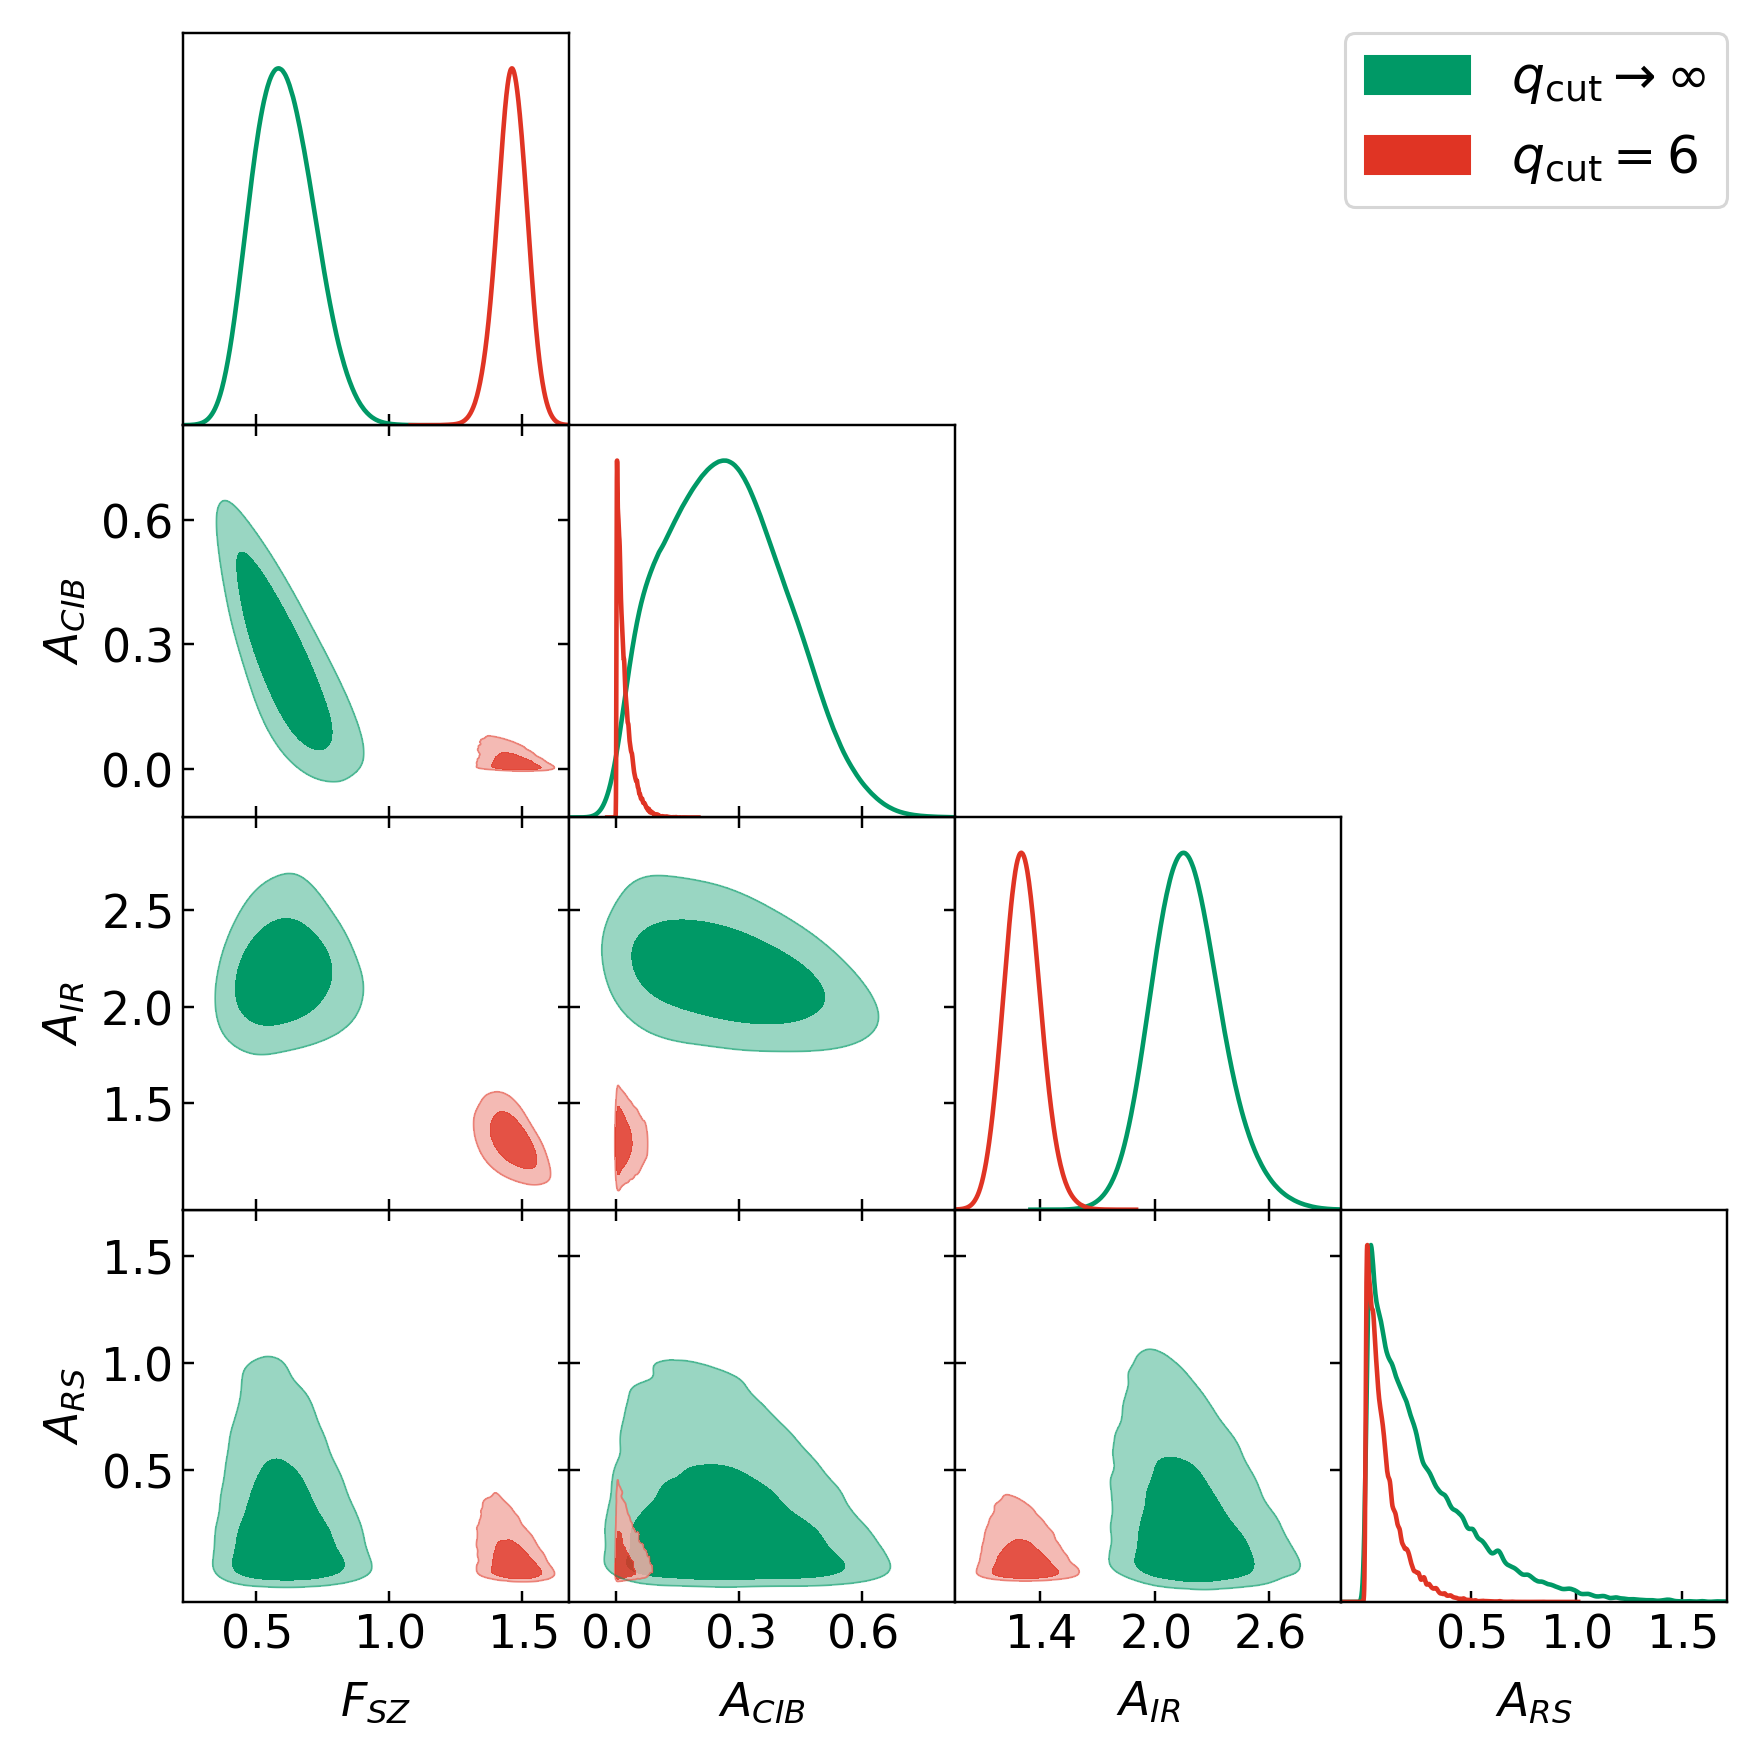

In [10]:
names=["F_sz", "A_cib", "A_ir", "A_rs"]#,"A_cn"]
tlbl=["F_{SZ}", "A_{CIB}", "A_{IR}", "A_{RS}"]#,"A_{CN}"]
samples_tot=MCSamples(samples=result["tot"]["samples"][:,:4],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_urc6=MCSamples(samples=result["urc6"]["samples"][:,:4],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize=20
g.settings.axes_fontsize=18
g.settings.axes_labelsize=18
g.settings.axis_tick_x_rotation=0

g.triangle_plot([samples_tot,samples_urc6],legend_loc="upper right",
                line_args=[{"lw":1.5,'color':'#009966'},{"ls":"-","lw":1.5,'color':'#E03424'},{"ls":"--","lw":1.5,'color':'blue'},{"ls":"--","lw":1.5,'color':'magenta'}], 
                contour_colors=['#009966','#E03424','blue','magenta'],filled=True)

# figname=figpath + "original_low_ell_cib_extp.jpeg"
# savefig(figname,bbox_inches="tight")

## Re-analyzed data

In [11]:
ana="rec" ; 
result={}
for  wdata in ["tot","urc6"]:
    pldata=np.copy(data_stat[ana][wdata])
    cl_thry=(clyy[wdata]["1h"]*clyy[wdata]["fl"])
    yyfit=fit_yy_params(pldata[:,3],pldata[:,4],tcov[wdata],cl_thry,cl_cib,cl_rs,cl_ir,cl_cn)
    result[wdata]=yyfit.emcee_fit(nwalkers=32,nsamples=5000,burnin=500)

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


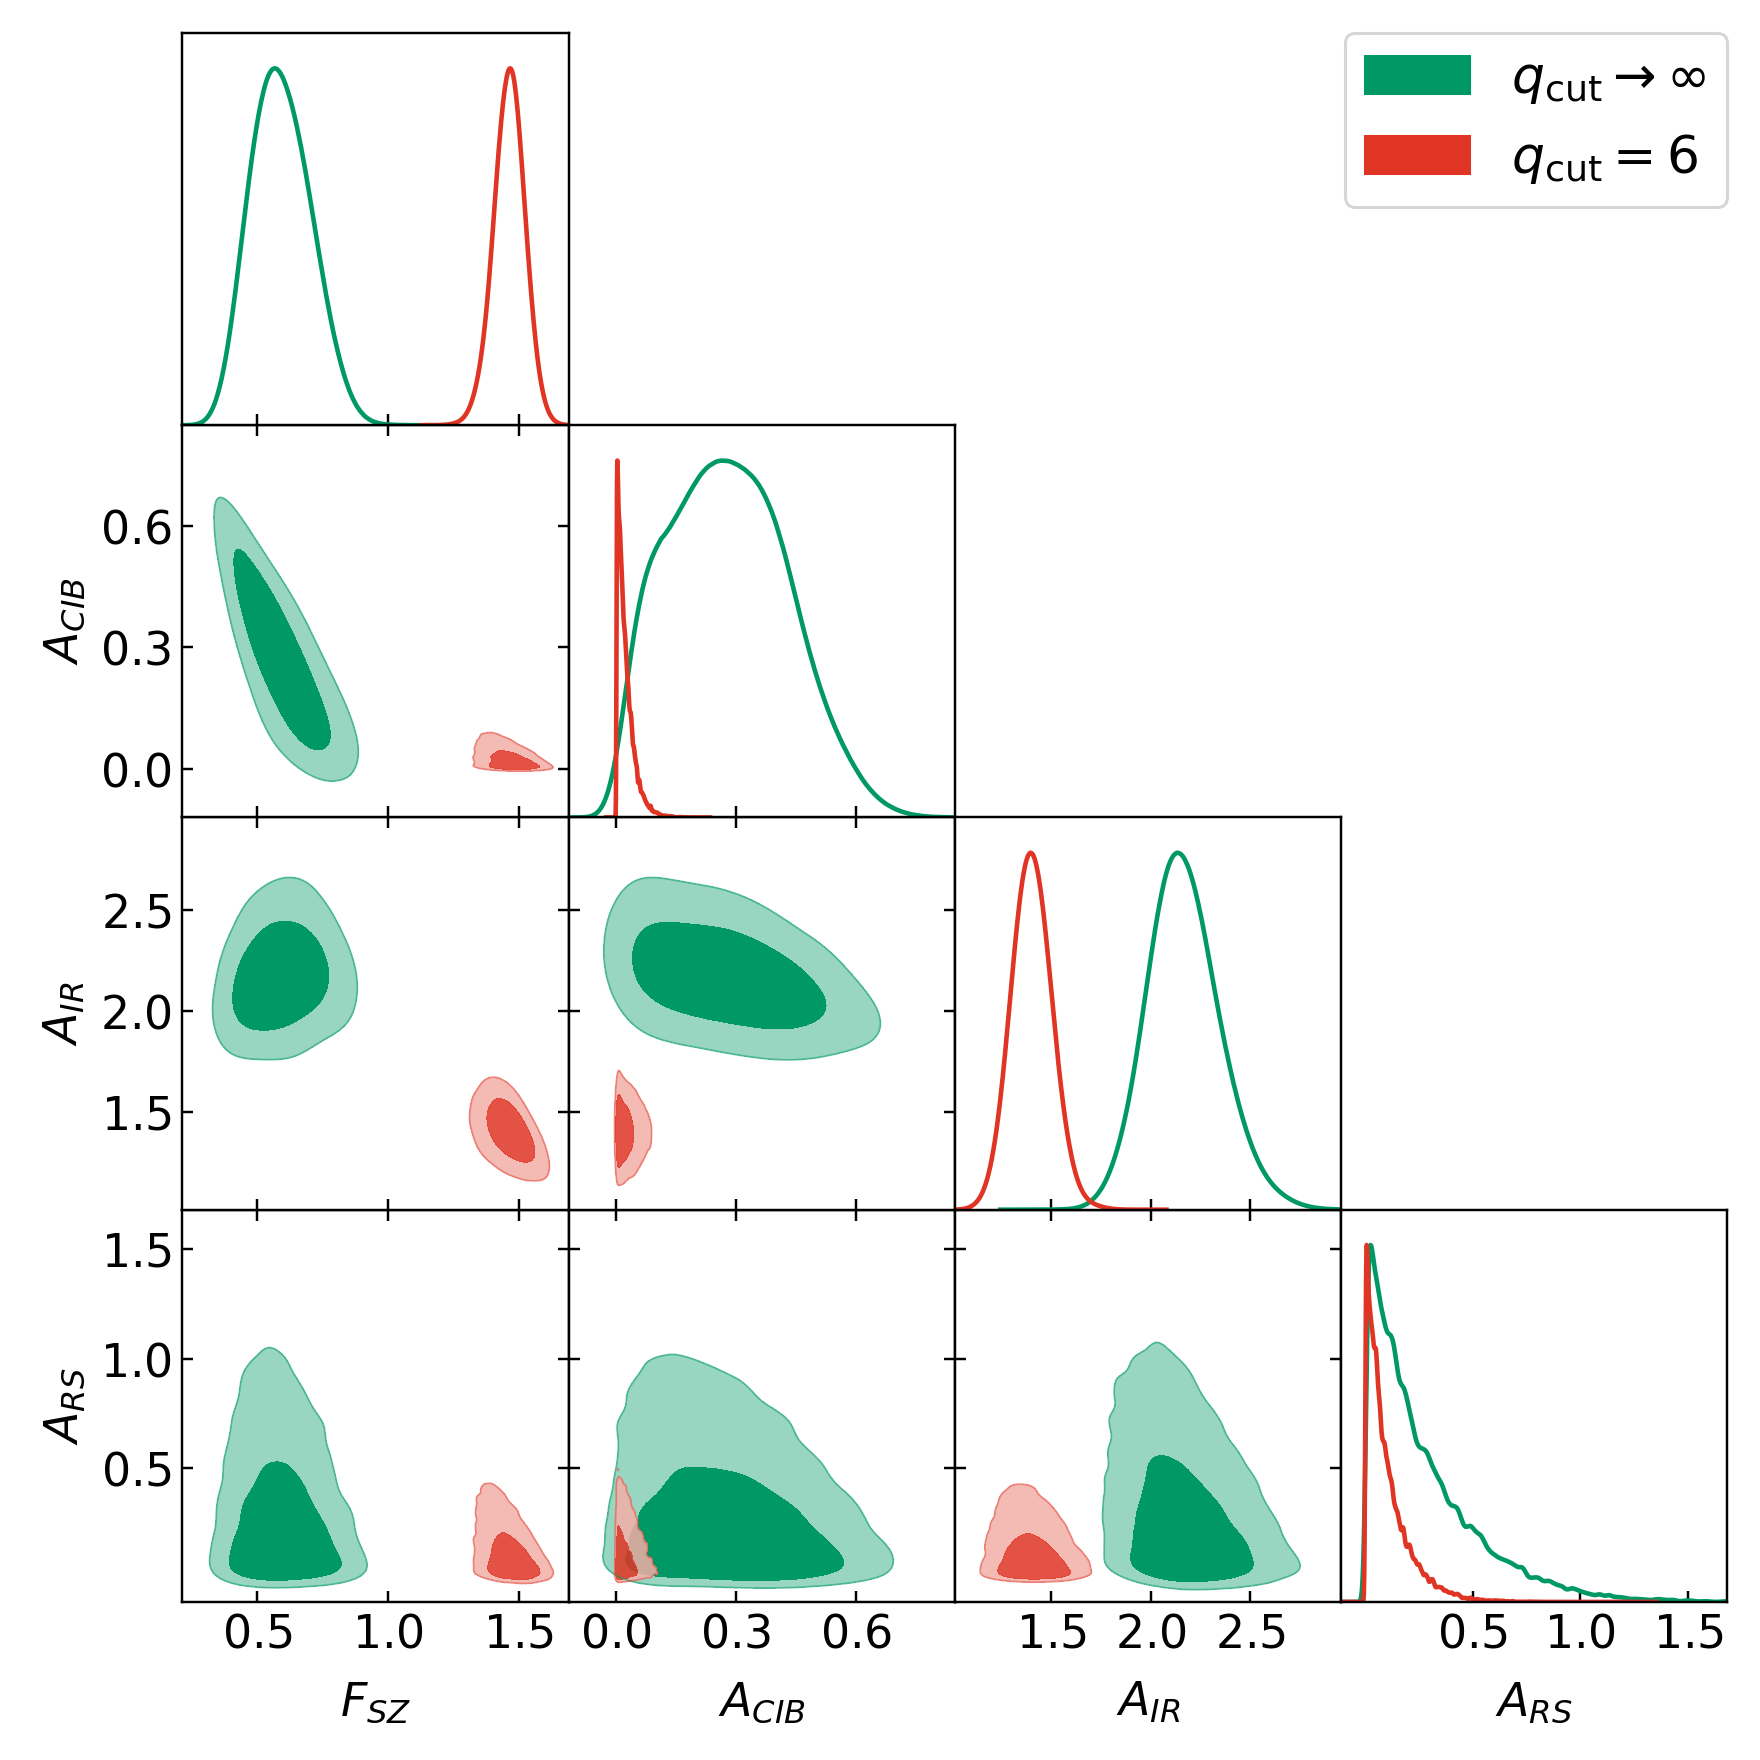

In [12]:
names=["F_sz", "A_cib", "A_ir", "A_rs"]#,"A_cn"]
tlbl=["F_{SZ}", "A_{CIB}", "A_{IR}", "A_{RS}"]#,"A_{CN}"]
samples_tot=MCSamples(samples=result["tot"]["samples"][:,:4],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_urc6=MCSamples(samples=result["urc6"]["samples"][:,:4],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize=20
g.settings.axes_fontsize=18
g.settings.axes_labelsize=18
g.settings.axis_tick_x_rotation=0

g.triangle_plot([samples_tot,samples_urc6],legend_loc="upper right",
                line_args=[{"lw":1.5,'color':'#009966'},{"ls":"-","lw":1.5,'color':'#E03424'},{"ls":"--","lw":1.5,'color':'blue'},{"ls":"--","lw":1.5,'color':'magenta'}], 
                contour_colors=['#009966','#E03424','blue','magenta'],filled=True)

# figname=figpath + "reanalyzed_low_ell_cib_extp.jpeg"
# savefig(figname,bbox_inches="tight")

## CIB deprojected

In [23]:
ana="cib_dep" ; 
result={}
for  wdata in ["tot","urc6"]:
    pldata=np.copy(data_stat[ana][wdata])
    cl_thry=(clyy[wdata]["1h"]*clyy[wdata]["fl"])
    yyfit=fit_yy_params(pldata[:,3],pldata[:,4],tcov[wdata],cl_thry,cl_cib,cl_rs,cl_ir,cl_cn)
    result[wdata]=yyfit.emcee_fit(nwalkers=32,nsamples=5000,burnin=500)

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


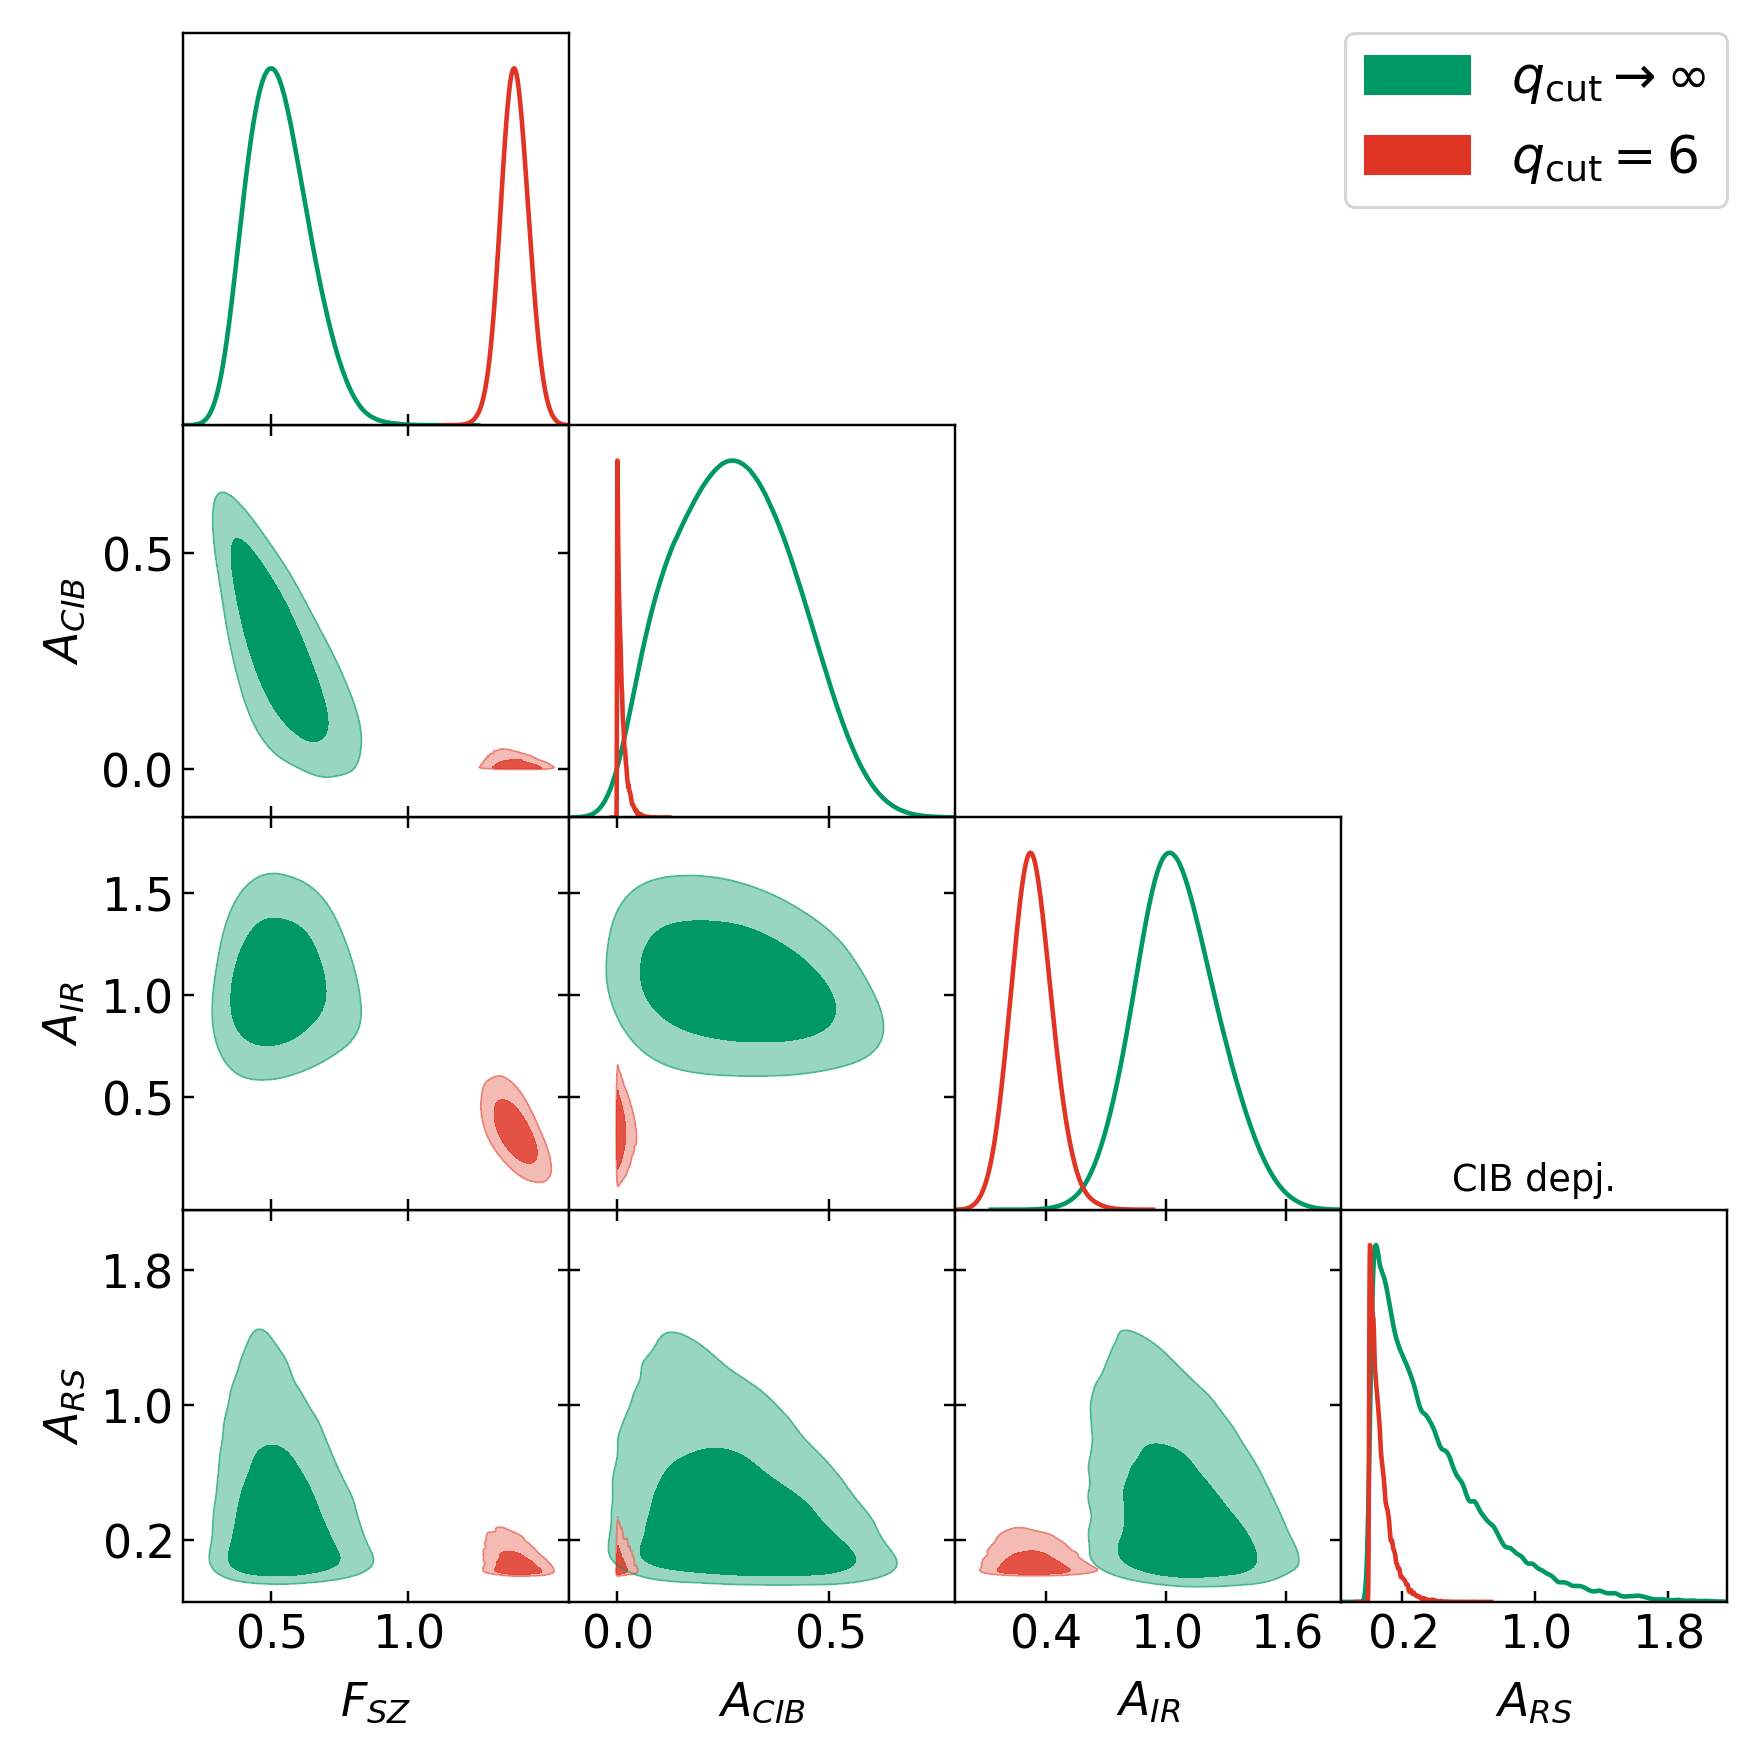

In [24]:
names=["F_sz", "A_cib", "A_ir", "A_rs"]#,"A_cn"]
tlbl=["F_{SZ}", "A_{CIB}", "A_{IR}", "A_{RS}"]#,"A_{CN}"]
samples_tot=MCSamples(samples=result["tot"]["samples"][:,:4],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_urc6=MCSamples(samples=result["urc6"]["samples"][:,:4],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize=20
g.settings.axes_fontsize=18
g.settings.axes_labelsize=18
g.settings.axis_tick_x_rotation=0

g.triangle_plot([samples_tot,samples_urc6],legend_loc="upper right",
                line_args=[{"lw":1.5,'color':'#009966'},{"ls":"-","lw":1.5,'color':'#E03424'},{"ls":"--","lw":1.5,'color':'blue'},{"ls":"--","lw":1.5,'color':'magenta'}], 
                contour_colors=['#009966','#E03424','blue','magenta'],filled=True)

if ana=="cib_dep_ds":
    title("CIB depj. downstream")
elif ana=="cib_dep_us":
    title("CIB depj. upstream")
else:
    title("CIB depj.")

figname=figpath + ana + ".pdf"
savefig(figname,bbox_inches="tight")
figname=figpath + ana + ".jpeg"
savefig(figname,bbox_inches="tight")

## All results together

In [70]:
result={}
for ana in ["rec","cib_dep"]:
    result[ana]={}
    for  wdata in ["tot","urc6"]:
        pldata=np.copy(data_stat[ana][wdata])
        cl_thry=(clyy[wdata]["1h"]*clyy[wdata]["fl"])
        yyfit=fit_yy_params(pldata[:,3],pldata[:,4],tcov[wdata],cl_thry,cl_cib,cl_rs,cl_ir,cl_cn)
        result[ana][wdata]=yyfit.emcee_fit(nwalkers=32,nsamples=5000,burnin=500)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


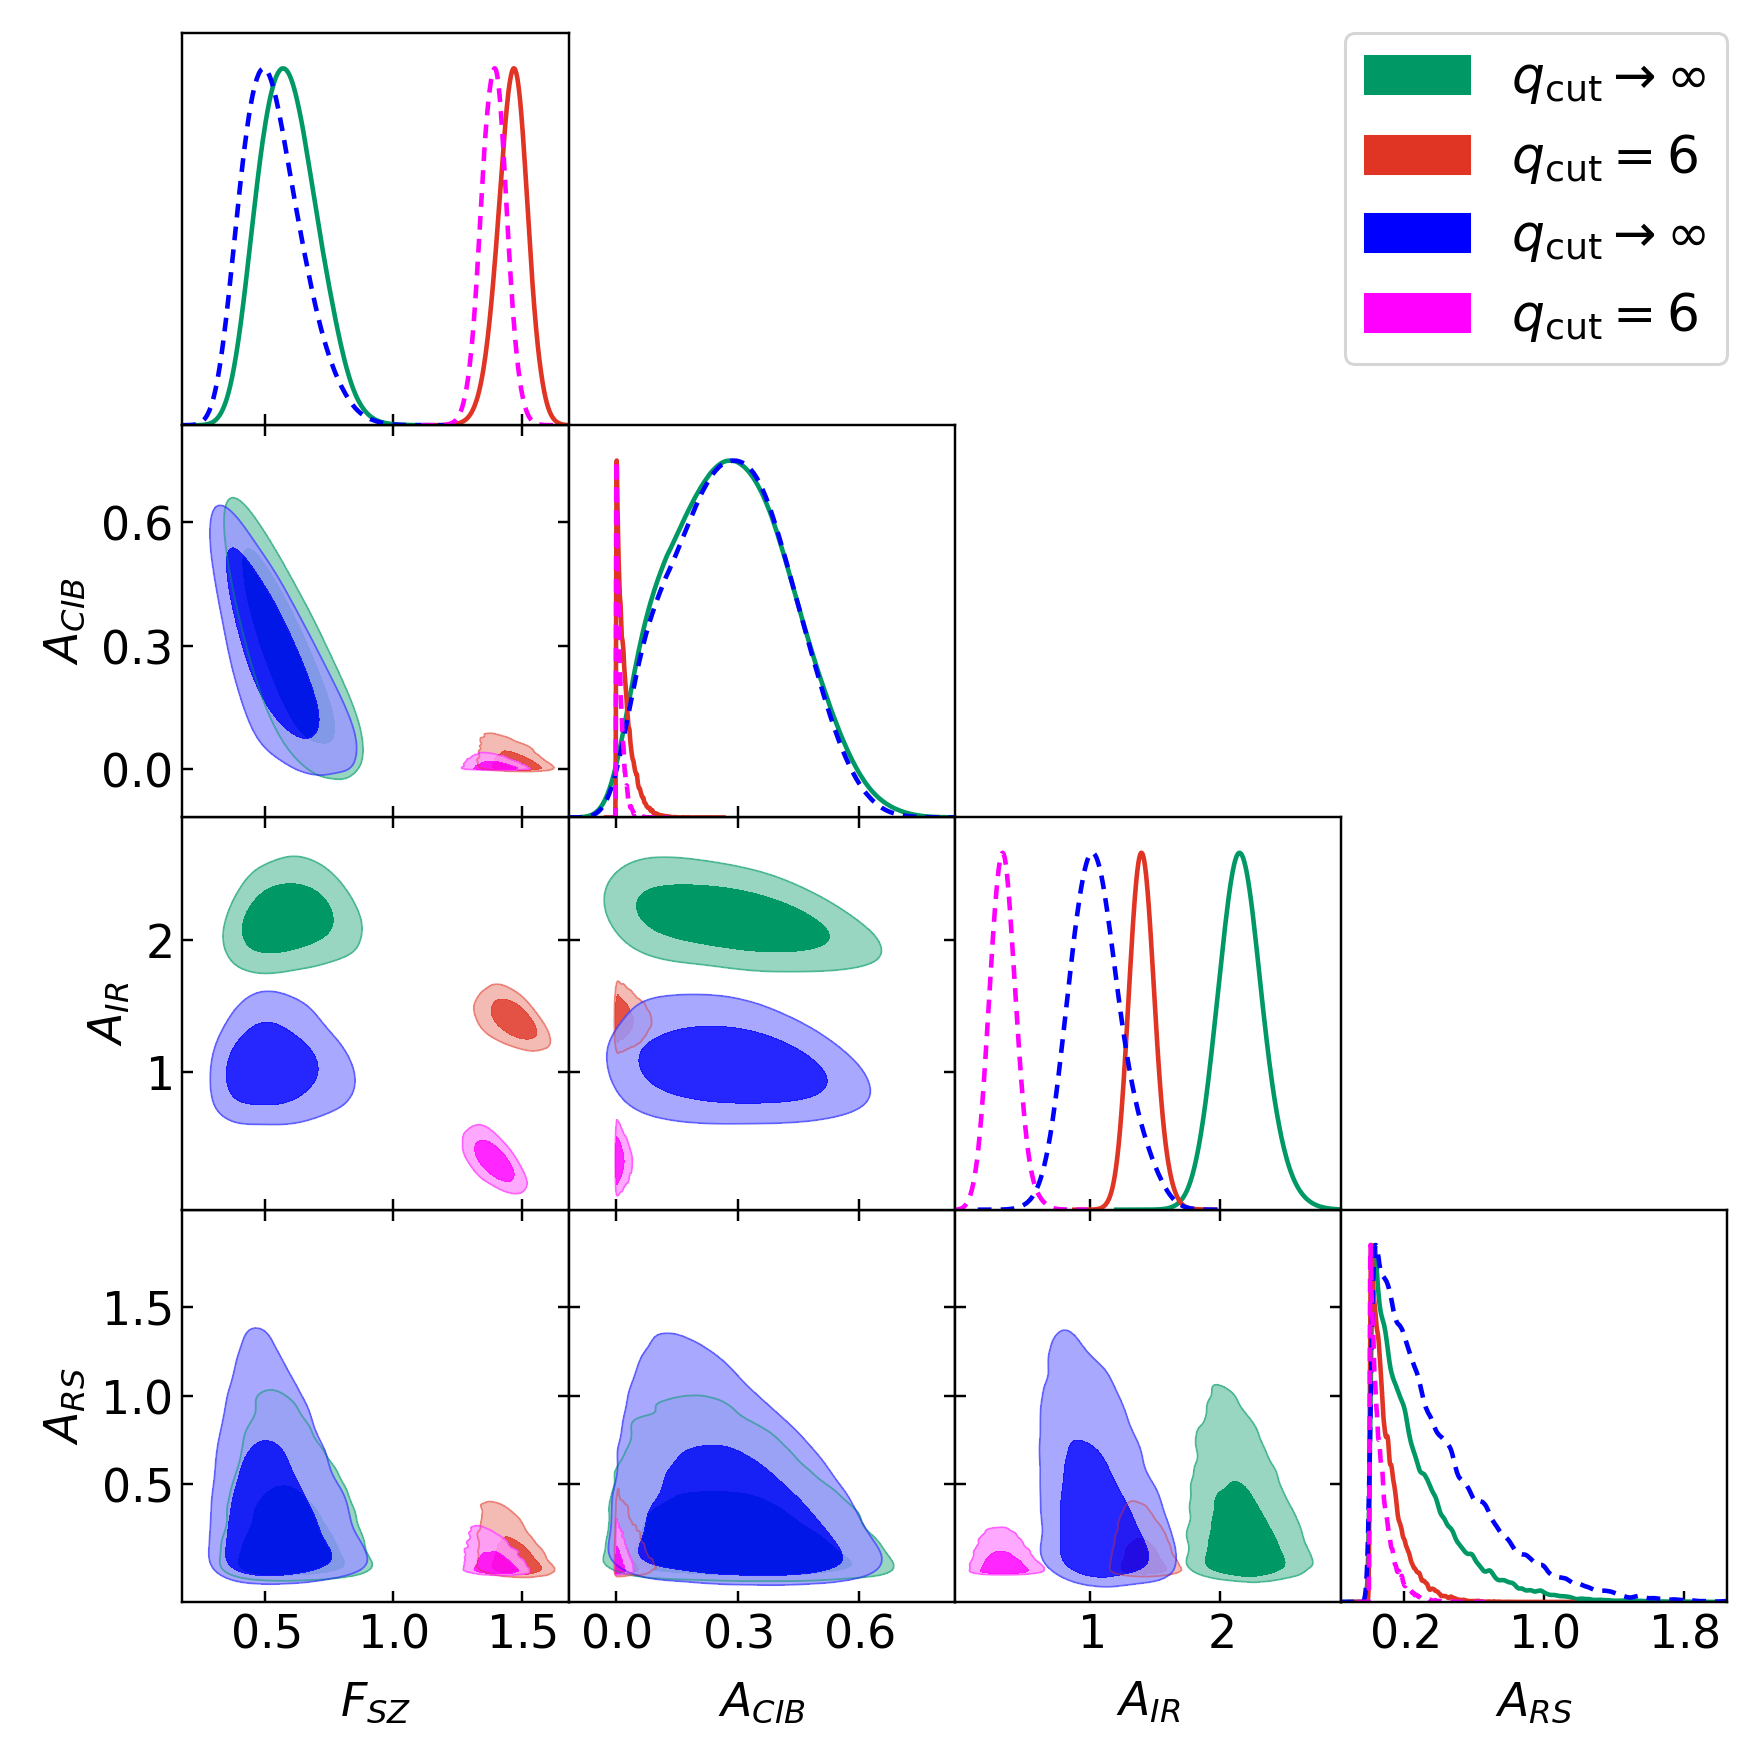

In [34]:
names=["F_sz", "A_cib", "A_ir", "A_rs"]#,"A_cn"]
tlbl=["F_{SZ}", "A_{CIB}", "A_{IR}", "A_{RS}"]#,"A_{CN}"]
samples_otot=MCSamples(samples=result["rec"]["tot"]["samples"][:,:4],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_ourc6=MCSamples(samples=result["rec"]["urc6"]["samples"][:,:4],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')
samples_dtot=MCSamples(samples=result["cib_dep"]["tot"]["samples"][:,:4],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_durc6=MCSamples(samples=result["cib_dep"]["urc6"]["samples"][:,:4],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize=20
g.settings.axes_fontsize=18
g.settings.axes_labelsize=18
g.settings.axis_tick_x_rotation=0

g.triangle_plot([samples_otot,samples_ourc6,samples_dtot,samples_durc6],legend_loc="upper right",
                line_args=[{"lw":1.5,'color':'#009966'},{"ls":"-","lw":1.5,'color':'#E03424'},{"ls":"--","lw":1.5,'color':'blue'},{"ls":"--","lw":1.5,'color':'magenta'}], 
                contour_colors=['#009966','#E03424','blue','magenta'],filled=True)

figname=figpath + "compare.jpeg"
savefig(figname,bbox_inches="tight")

# MCMC analysis - no CIB deprojection

## Original data

In [10]:
ana="orig" ; 
result={}
for  wdata in ["tot","urc6"]:
    pldata=np.copy(data_stat[ana][wdata])
    cl_thry=(clyy[wdata]["1h"]*clyy[wdata]["fl"])
    yyfit=fit_yy_params_no_cib(pldata[:,3],pldata[:,4],tcov[wdata],cl_thry,cl_rs,cl_ir,cl_cn)
    result[wdata]=yyfit.emcee_fit(nwalkers=32,nsamples=5000,burnin=500)

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


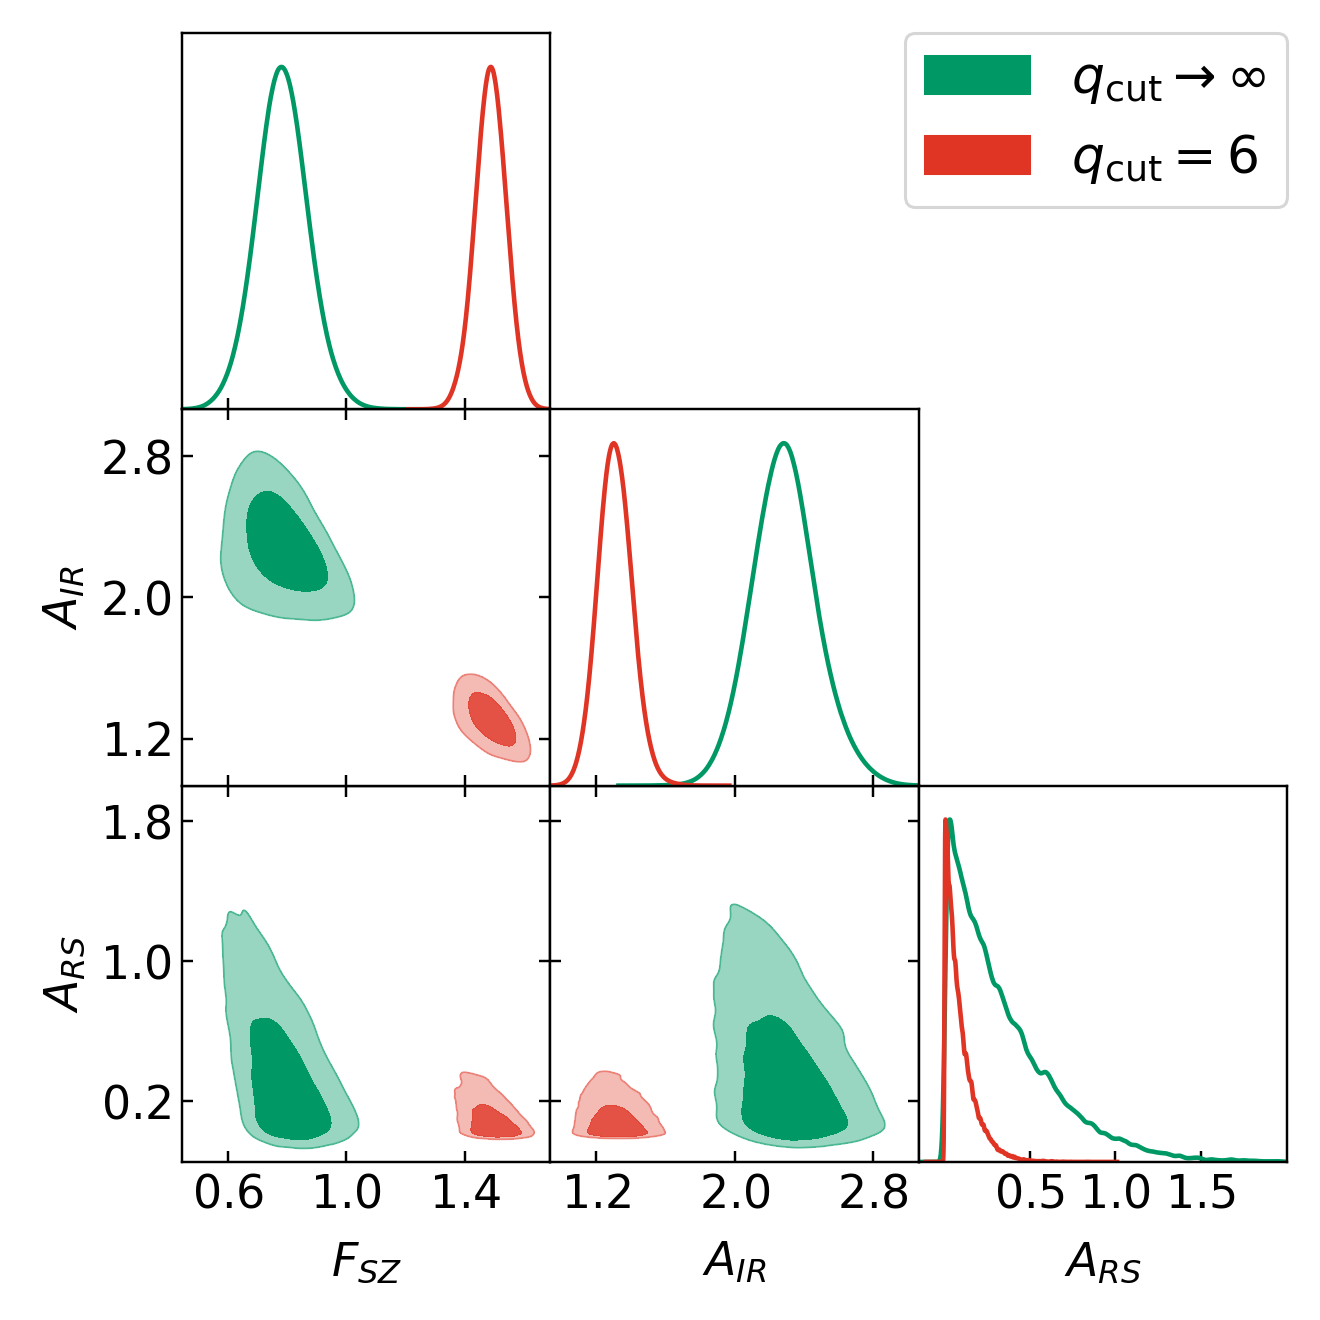

In [12]:
names=["F_sz", "A_ir", "A_rs"]#,"A_cn"]
tlbl=["F_{SZ}", "A_{IR}", "A_{RS}"]#,"A_{CN}"]
samples_tot=MCSamples(samples=result["tot"]["samples"][:,:3],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_urc6=MCSamples(samples=result["urc6"]["samples"][:,:3],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize=20
g.settings.axes_fontsize=18
g.settings.axes_labelsize=18
g.settings.axis_tick_x_rotation=0

g.triangle_plot([samples_tot,samples_urc6],legend_loc="upper right",
                line_args=[{"lw":1.5,'color':'#009966'},{"ls":"-","lw":1.5,'color':'#E03424'},{"ls":"--","lw":1.5,'color':'blue'},{"ls":"--","lw":1.5,'color':'magenta'}], 
                contour_colors=['#009966','#E03424','blue','magenta'],filled=True)

# figname=figpath + "original_low_ell_cib_extp.jpeg"
# savefig(figname,bbox_inches="tight")

## CIB deprojected data

In [13]:
ana="cib_dep" ; 
result={}
for  wdata in ["tot","urc6"]:
    pldata=np.copy(data_stat[ana][wdata])
    cl_thry=(clyy[wdata]["1h"]*clyy[wdata]["fl"])
    yyfit=fit_yy_params_no_cib(pldata[:,3],pldata[:,4],tcov[wdata],cl_thry,cl_rs,cl_ir,cl_cn)
    result[wdata]=yyfit.emcee_fit(nwalkers=32,nsamples=5000,burnin=500)

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


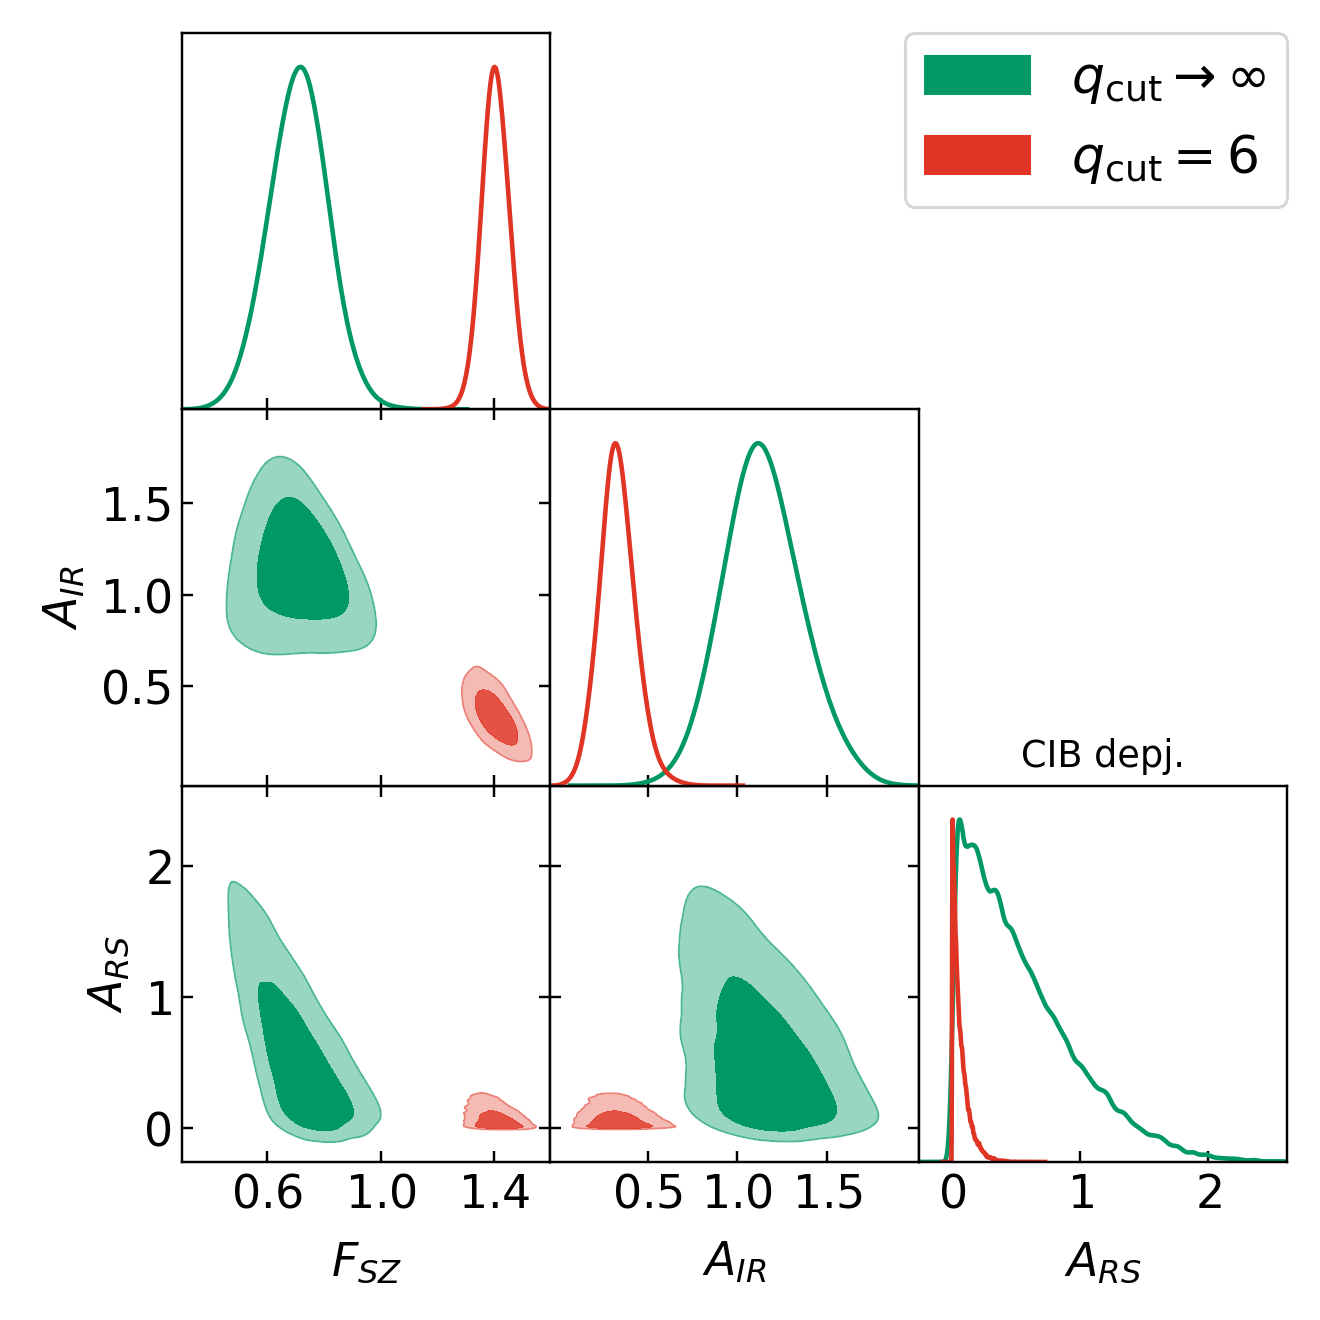

In [14]:
names=["F_sz", "A_ir", "A_rs"]#,"A_cn"]
tlbl=["F_{SZ}", "A_{IR}", "A_{RS}"]#,"A_{CN}"]
samples_tot=MCSamples(samples=result["tot"]["samples"][:,:3],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_urc6=MCSamples(samples=result["urc6"]["samples"][:,:3],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize=20
g.settings.axes_fontsize=18
g.settings.axes_labelsize=18
g.settings.axis_tick_x_rotation=0

g.triangle_plot([samples_tot,samples_urc6],legend_loc="upper right",
                line_args=[{"lw":1.5,'color':'#009966'},{"ls":"-","lw":1.5,'color':'#E03424'},{"ls":"--","lw":1.5,'color':'blue'},{"ls":"--","lw":1.5,'color':'magenta'}], 
                contour_colors=['#009966','#E03424','blue','magenta'],filled=True)

if ana=="cib_dep_ds":
    title("CIB depj. downstream")
elif ana=="cib_dep_us":
    title("CIB depj. upstream")
else:
    title("CIB depj.")

# figname=figpath + ana + ".pdf"
# savefig(figname,bbox_inches="tight")
# figname=figpath + ana + ".jpeg"
# savefig(figname,bbox_inches="tight")

## All results together

In [15]:
result={}
for ana in ["rec","cib_dep"]:
    result[ana]={}
    for  wdata in ["tot","urc6"]:
        pldata=np.copy(data_stat[ana][wdata])
        cl_thry=(clyy[wdata]["1h"]*clyy[wdata]["fl"])
        yyfit=fit_yy_params_no_cib(pldata[:,3],pldata[:,4],tcov[wdata],cl_thry,cl_rs,cl_ir,cl_cn)
        result[ana][wdata]=yyfit.emcee_fit(nwalkers=32,nsamples=5000,burnin=500)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


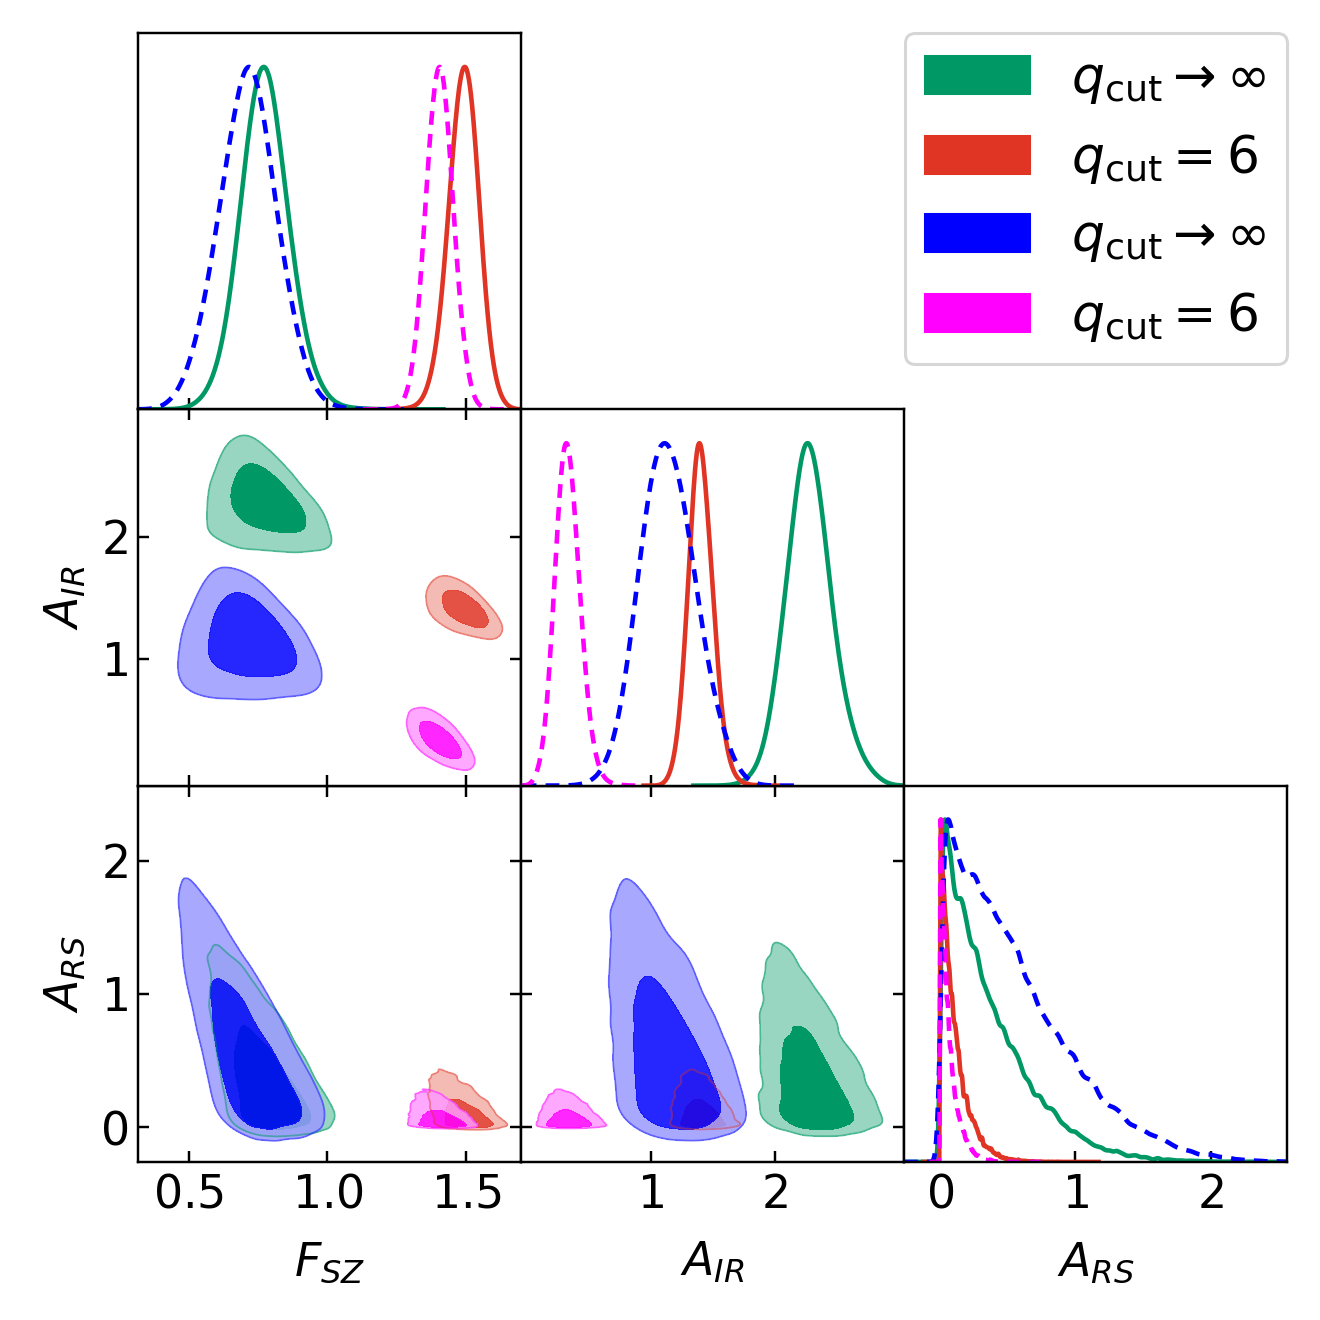

In [16]:
names=["F_sz", "A_ir", "A_rs"]#,"A_cn"]
tlbl=["F_{SZ}", "A_{IR}", "A_{RS}"]#,"A_{CN}"]
samples_otot=MCSamples(samples=result["rec"]["tot"]["samples"][:,:3],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_ourc6=MCSamples(samples=result["rec"]["urc6"]["samples"][:,:3],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')
samples_dtot=MCSamples(samples=result["cib_dep"]["tot"]["samples"][:,:3],names = names,labels = tlbl, label=r'$q_{\rm cut} \rightarrow \infty$',)
samples_durc6=MCSamples(samples=result["cib_dep"]["urc6"]["samples"][:,:3],names = names, labels = tlbl,label=r'$q_{\rm cut} = 6$')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize=20
g.settings.axes_fontsize=18
g.settings.axes_labelsize=18
g.settings.axis_tick_x_rotation=0

g.triangle_plot([samples_otot,samples_ourc6,samples_dtot,samples_durc6],legend_loc="upper right",
                line_args=[{"lw":1.5,'color':'#009966'},{"ls":"-","lw":1.5,'color':'#E03424'},{"ls":"--","lw":1.5,'color':'blue'},{"ls":"--","lw":1.5,'color':'magenta'}], 
                contour_colors=['#009966','#E03424','blue','magenta'],filled=True)

figname=figpath + "compare_no_cib_dep.jpeg"
savefig(figname,bbox_inches="tight")

# Miscellaneous plots

<IPython.core.display.Javascript object>


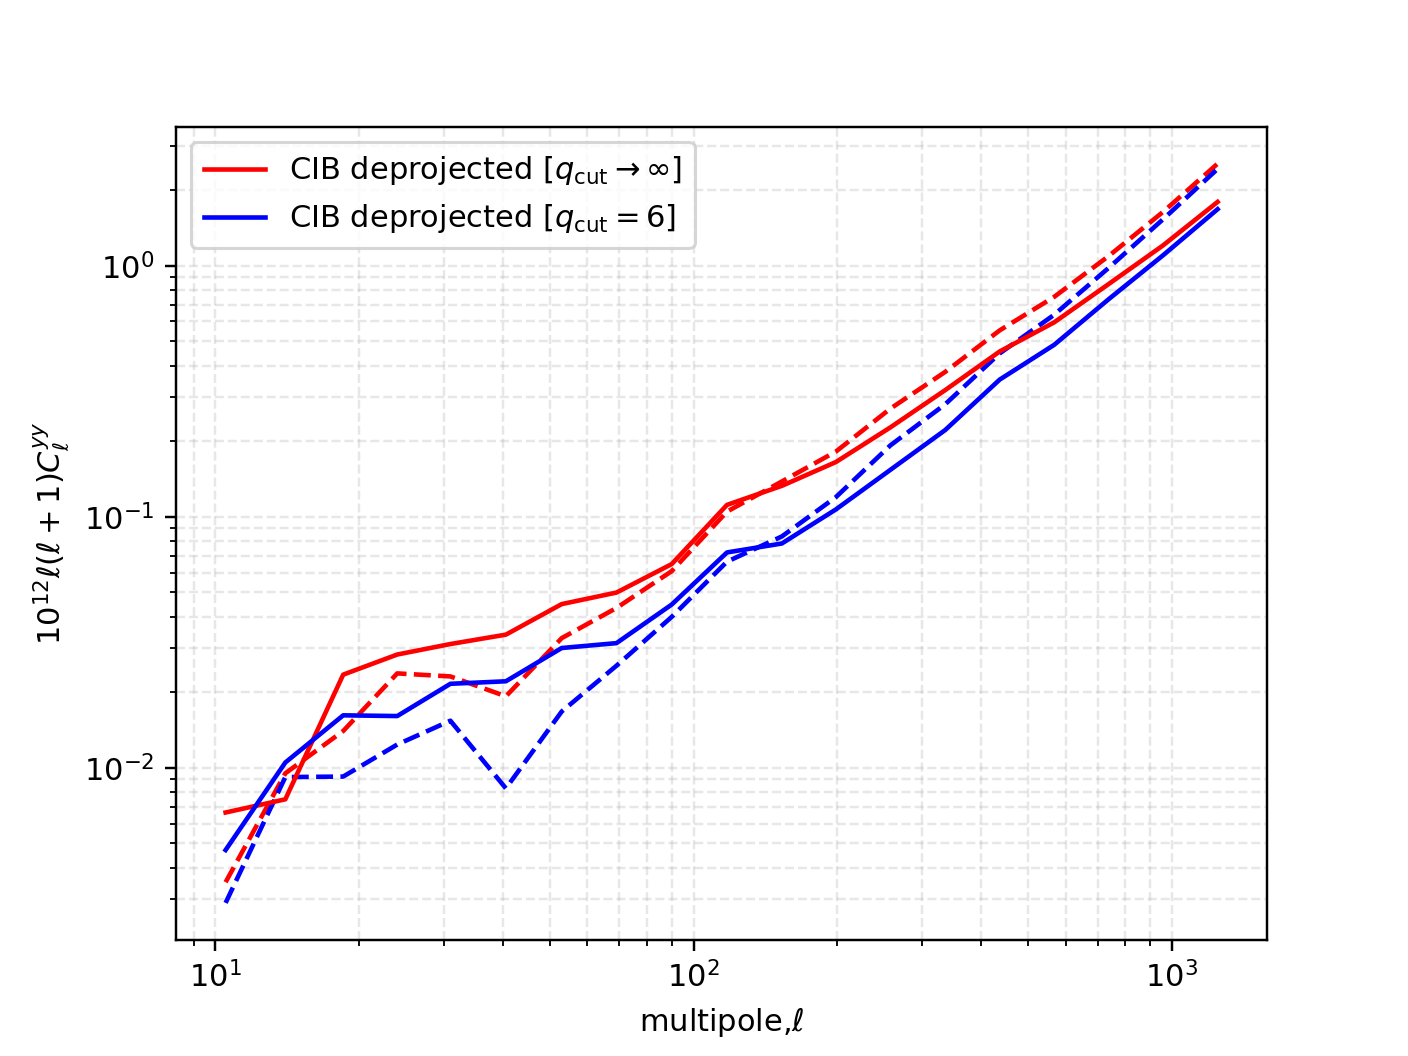

<IPython.core.display.Javascript object>


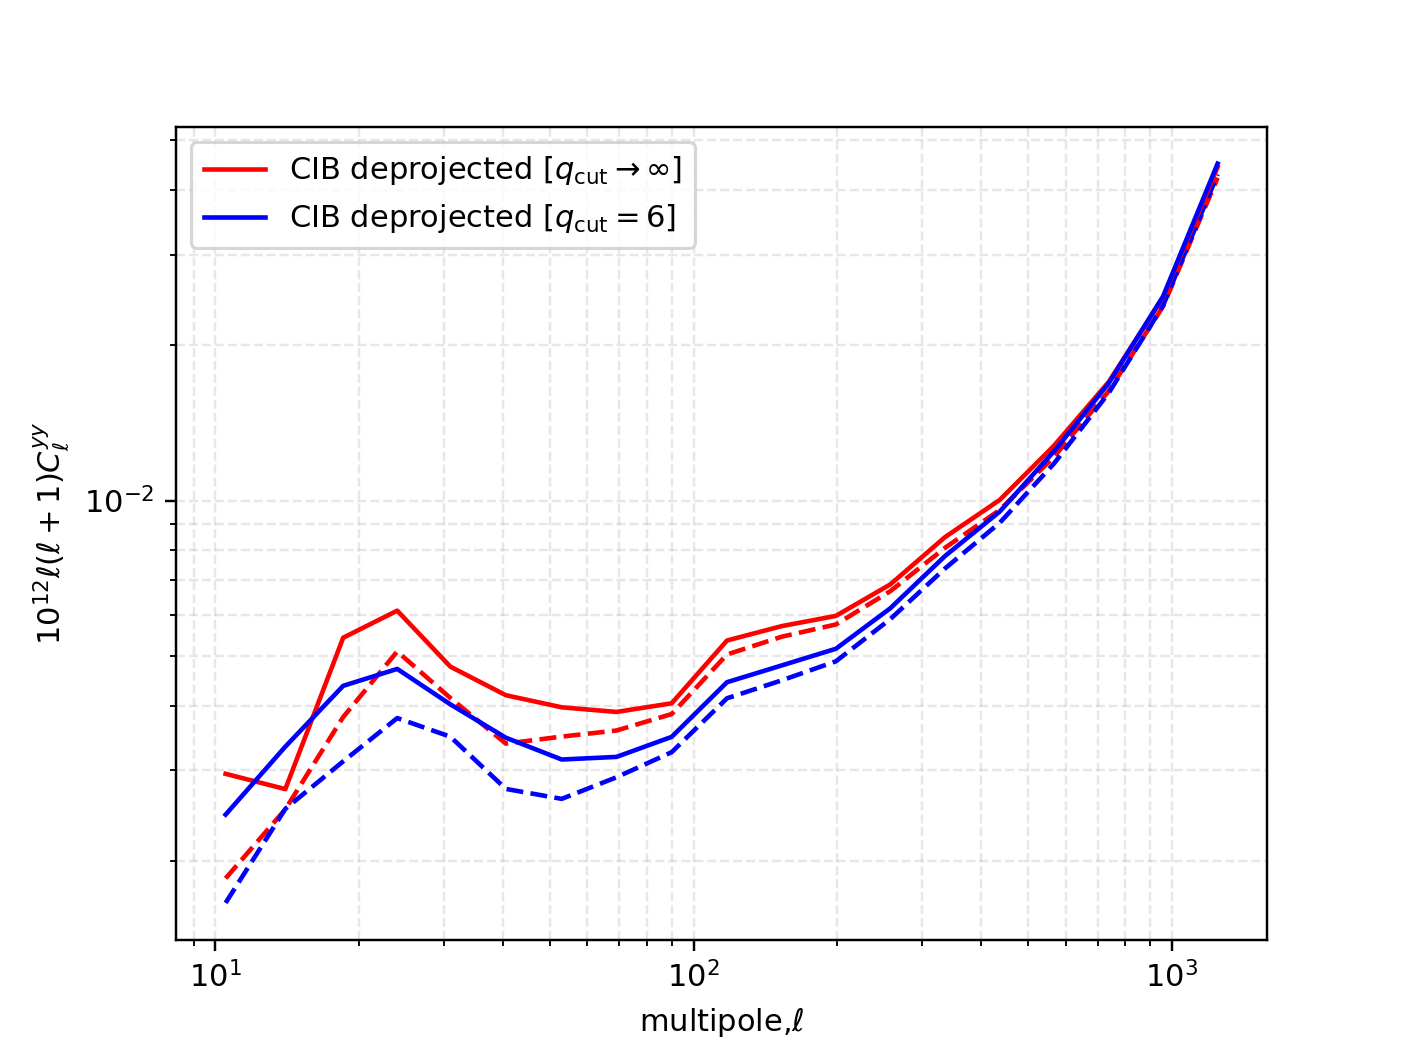

In [81]:
figure()
plot(data_stat["rec"]["tot"][:,2],data_stat["rec"]["tot"][:,3],"r--",label="")
plot(data_stat["rec"]["urc6"][:,2],data_stat["rec"]["urc6"][:,3],"b--",label="")
plot(data_stat["cib_dep"]["tot"][:,2],data_stat["cib_dep"]["tot"][:,3],"r-",label=r"CIB deprojected $[q_{\rm cut} \rightarrow \infty ]$")
plot(data_stat["cib_dep"]["urc6"][:,2],data_stat["cib_dep"]["urc6"][:,3],"b-",label=r"CIB deprojected $[q_{\rm cut} = 6 ]$")
xlabel("multipole,$\ell$",fontsize=10)
ylabel(r"$10^{12}\ell(\ell+1)C_{\ell}^{yy}$",fontsize=10)
grid(which="both",alpha=0.3,linestyle="--")
legend()
loglog()
figname=figpath + 'compare_spectra.pdf'
savefig(figname,bbox_inches="tight")

figure()
plot(data_stat["rec"]["tot"][:,2],data_stat["rec"]["tot"][:,4],"r--",label="")
plot(data_stat["rec"]["urc6"][:,2],data_stat["rec"]["urc6"][:,4],"b--",label="")
plot(data_stat["cib_dep"]["tot"][:,2],data_stat["cib_dep"]["tot"][:,4],"r-",label=r"CIB deprojected $[q_{\rm cut} \rightarrow \infty ]$")
plot(data_stat["cib_dep"]["urc6"][:,2],data_stat["cib_dep"]["urc6"][:,4],"b-",label=r"CIB deprojected $[q_{\rm cut} = 6 ]$")
xlabel("multipole,$\ell$",fontsize=10)
ylabel(r"$10^{12}\ell(\ell+1)C_{\ell}^{yy}$",fontsize=10)
grid(which="both",alpha=0.3,linestyle="--")
legend()
loglog()
figname=figpath + 'compare_spectra_err.pdf'
savefig(figname,bbox_inches="tight")

In [82]:
print result["rec"]["tot"]["param"]
print result["cib_dep"]["tot"]["param"]

[0.58977651 0.28210197 2.16452933 0.26503298 8.06247056]
[0.5311977  0.27963582 1.06670783 0.3742227  6.96384022]


In [27]:
# Data from Boris's papers
planck_yy=np.loadtxt("/Users/adityarotti/Documents/Work/Data/Planck/" + "/maps/bolliet2018.txt")

<IPython.core.display.Javascript object>


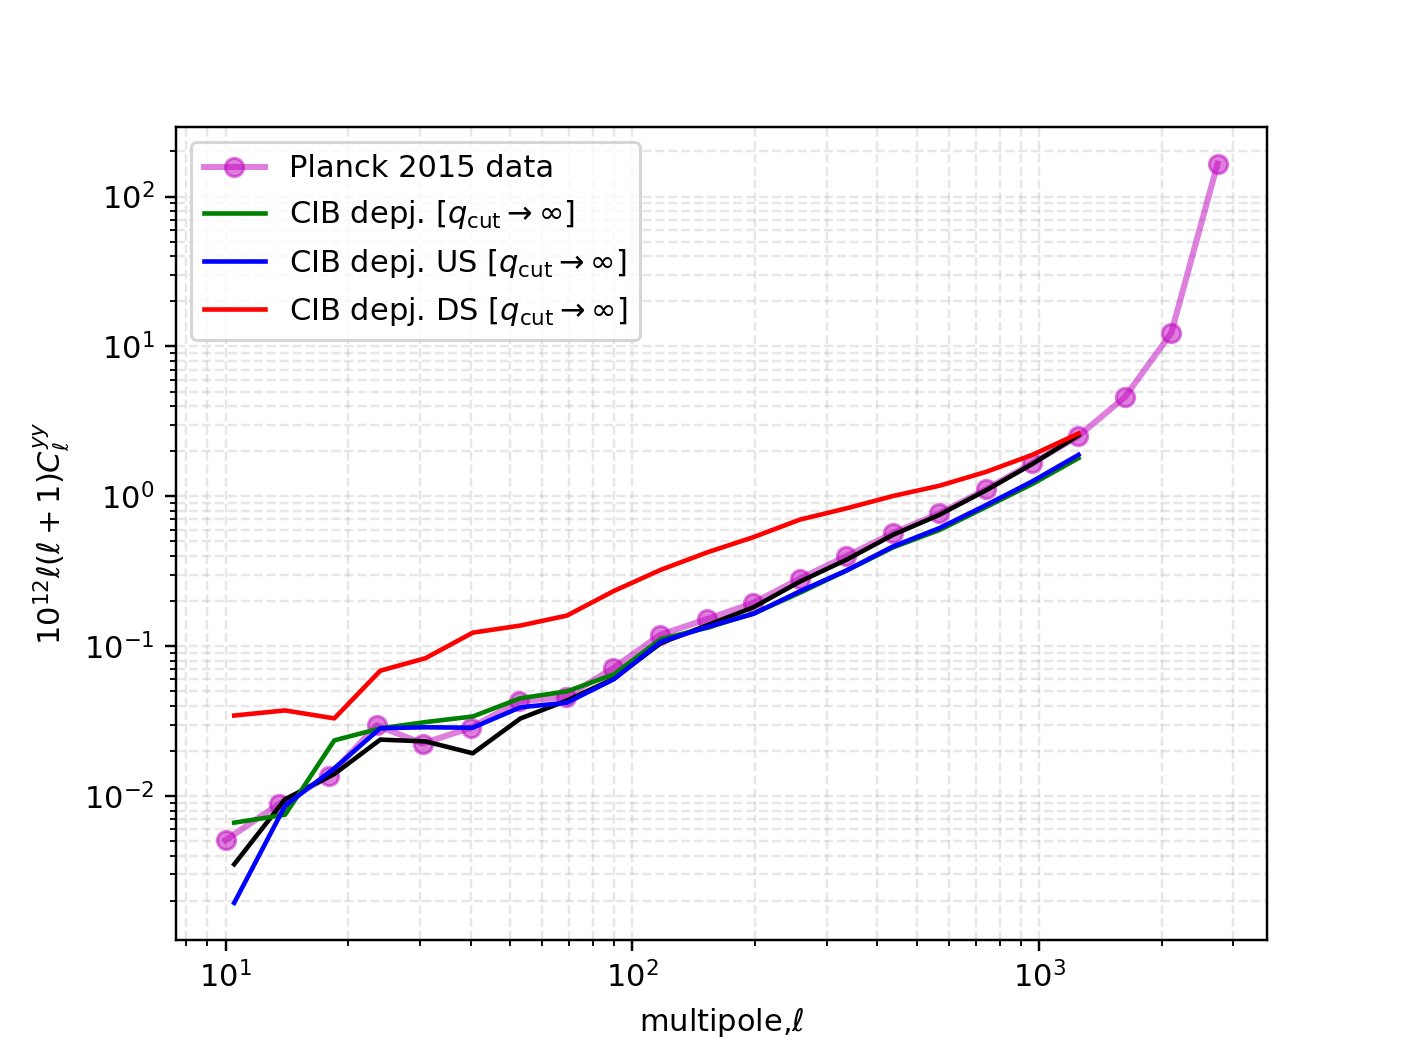

In [31]:
figure()
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data",alpha=0.5)
plot(data_stat["rec"]["tot"][:,2],data_stat["rec"]["tot"][:,3],"k-",label="")
plot(data_stat["cib_dep"]["tot"][:,2],data_stat["cib_dep"]["tot"][:,3],"g-",label=r"CIB depj. $[q_{\rm cut} \rightarrow \infty ]$")
plot(data_stat["cib_dep_us"]["tot"][:,2],data_stat["cib_dep_us"]["tot"][:,3],"b-",label=r"CIB depj. US $[q_{\rm cut} \rightarrow \infty ]$")
plot(data_stat["cib_dep_ds"]["tot"][:,2],data_stat["cib_dep_ds"]["tot"][:,3],"r-",label=r"CIB depj. DS $[q_{\rm cut} \rightarrow \infty ]$")
xlabel("multipole,$\ell$",fontsize=10)
ylabel(r"$10^{12}\ell(\ell+1)C_{\ell}^{yy}$",fontsize=10)
grid(which="both",alpha=0.3,linestyle="--")
legend()
loglog()
figname=figpath + 'compare_spectra.pdf'
savefig(figname,bbox_inches="tight")